In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.utils.data as dataloader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data_transformation=transforms.Compose([transforms.ToTensor()])

Download Dataset(MNIST)-PIL

In [ ]:
train_dataset=torchvision.datasets.MNIST(root='./data',train=True,transform=data_transformation,download=True)
val_dataset=torchvision.datasets.MNIST(root='./data',train=False,transform=data_transformation,download=True)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.64MB/s]


Variables

In [ ]:
img_size=28
num_channels=1
patch_size=7
num_patches=(img_size//patch_size)**2
print(num_patches)
token_dim=32
num_heads=4
num_layers=4 #number of transformer layers
mlp_hidden_dim=4*token_dim
num_classes=10
learning_rate=3e-4
epochs=5
batch_size=64



16


Create Batches for neural network training


In [ ]:
train_loader=dataloader.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader=dataloader.DataLoader(val_dataset,batch_size=batch_size,shuffle=False)



Part 1 of ViT:Patch Embedding

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embed=nn.Conv2d(num_channels,token_dim,kernel_size=patch_size,stride=patch_size)

  def forward(self,x):
      x=self.patch_embed(x)
      x=x.flatten(2)
      x=x.transpose(1,2)
      return x

Part 2 of ViT:Transformer Encoder

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.layernorm1=nn.LayerNorm(token_dim)
    self.layernorm2=nn.LayerNorm(token_dim)
    self.multihead_attention=nn.MultiheadAttention(token_dim,num_heads,batch_first=True)
    self.mlp=nn.Sequential(
        nn.Linear(token_dim,mlp_hidden_dim),
        nn.GELU(),
        nn.Linear(mlp_hidden_dim,token_dim)
    )
  def forward(self,x):
    residual1=x
    x=self.layernorm1(x)
    x=self.multihead_attention(x,x,x)[0]
    x=x+residual1

    residual2=x
    x=self.layernorm2(x)
    x=self.mlp(x)
    x=x+residual2
    return x



Part 3 of ViT:MLP Classification

In [ ]:
class MLPHead(nn.Module):
  def __init__(self):
    super().__init__()
    self.layernorm=nn.LayerNorm(token_dim)
    self.mlp=nn.Linear(token_dim,num_classes)

  def forward(self,x):
    x=self.layernorm(x)
    x=self.mlp(x)
    return x

Combined Parts

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding=PatchEmbedding()
    self.cls_token=nn.Parameter(torch.randn(1,1,token_dim))
    self.postion_embedding=nn.Parameter(torch.randn(1,num_patches+1,token_dim))
    self.transformer_encoder=nn.Sequential(*[TransformerEncoder() for _ in range(num_layers)])
    self.mlp_head=MLPHead()

  def forward(self,x):
    x=self.patch_embedding(x)
    num_image_in_batch=x.shape[0]
    cls_token=self.cls_token.expand(num_image_in_batch,-1,-1)
    x=torch.cat((cls_token,x),dim=1)
    x=x+self.postion_embedding
    x=self.transformer_encoder(x)
    x=x[:,0]
    x=self.mlp_head(x)
    return x

In [ ]:
device=torch.device('cuda'if torch.cuda.is_available()else 'cpu')

In [ ]:
model=VisionTransformer().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion=nn.CrossEntropyLoss()

In [ ]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_epoch = 0
    total_epoch = 0
    print(f"Epoch: {epoch+1}")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # Accumulate total loss over the epoch

        preds = outputs.argmax(dim=1)
        correct = (preds == labels).sum().item()
        correct_epoch += correct
        total_epoch += labels.size(0)

        accuracy = 100.0 * correct / labels.size(0)

        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx+1:3d}: Loss={loss.item():.4f}, Accuracy={accuracy:.2f}%')

    # Calculate average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Calculate accuracy for the epoch
    epoch_acc = 100.0 * correct_epoch / total_epoch

    # Print epoch summary with average loss
    print(f'==> Epoch {epoch+1} Summary: Average Loss={average_loss:.4f}, Accuracy={epoch_acc:.2f}%')


Epoch: 1
Batch   1: Loss=0.0045, Accuracy=100.00%
Batch 101: Loss=0.0051, Accuracy=100.00%
Batch 201: Loss=0.0142, Accuracy=98.44%
Batch 301: Loss=0.0783, Accuracy=98.44%
Batch 401: Loss=0.0930, Accuracy=93.75%
Batch 501: Loss=0.0046, Accuracy=100.00%
Batch 601: Loss=0.0197, Accuracy=100.00%
Batch 701: Loss=0.0087, Accuracy=100.00%
Batch 801: Loss=0.0856, Accuracy=98.44%
Batch 901: Loss=0.0309, Accuracy=98.44%
==> Epoch 1 Summary: Average Loss=0.0281, Accuracy=99.10%
Epoch: 2
Batch   1: Loss=0.0158, Accuracy=100.00%
Batch 101: Loss=0.1004, Accuracy=96.88%
Batch 201: Loss=0.0123, Accuracy=100.00%
Batch 301: Loss=0.0129, Accuracy=98.44%
Batch 401: Loss=0.2877, Accuracy=95.31%
Batch 501: Loss=0.0152, Accuracy=100.00%
Batch 601: Loss=0.0285, Accuracy=98.44%
Batch 701: Loss=0.0410, Accuracy=98.44%
Batch 801: Loss=0.0693, Accuracy=96.88%
Batch 901: Loss=0.0061, Accuracy=100.00%
==> Epoch 2 Summary: Average Loss=0.0245, Accuracy=99.21%
Epoch: 3
Batch   1: Loss=0.1256, Accuracy=98.44%
Batch 10

In [ ]:
model.eval()
correct=0
total=0
with torch.no_grad():
  for images,labels in val_loader:
    images,labels=images.to(device),labels.to(device)
    outputs=model(images)
    preds=outputs.argmax(dim=1)
    correct+=(preds==labels).sum().item()
    total+=labels.size(0)

test_acc=100.0*correct/total
print(f"\n==>Val Acc:{test_acc:.2f}%")



==>Val Acc:97.88%


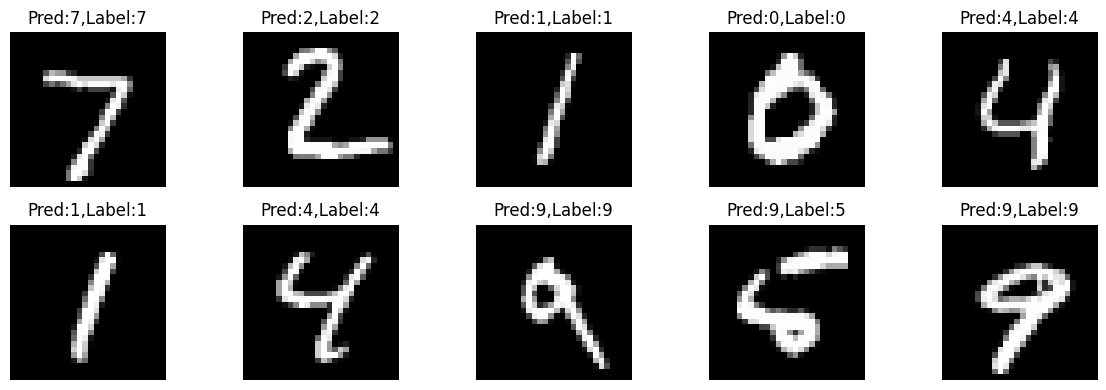

In [ ]:
import matplotlib.pyplot as plt

model.eval()
images,labels=next(iter(val_loader))
images,labels=images.to(device),labels.to(device)
with torch.no_grad():
  outputs=model(images)
  preds=outputs.argmax(dim=1)
images=images.cpu()
pred=preds.cpu()
labels=labels.cpu()

plt.figure(figsize=(12,4))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(images[i].squeeze(),cmap='gray')
  plt.title(f"Pred:{pred[i].item()},Label:{labels[i].item()}")
  plt.axis('off')
plt.tight_layout()
plt.show()